# Выбор локации для скважины

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

<b>Задача проекта</b> - построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 

<b>Цель проекта</b> - определить регион для разработки.

<b>Данные:</b>
- <i>id</i> — уникальный идентификатор скважины;
- <i>f0, f1, f2</i> — три признака точек (неважно, что они означают, но сами признаки значимы);
- <i>product</i> — объём запасов в скважине (тыс. баррелей).

<b>План проекта:</b>
1. Загрузить и подготовить данные;
2. Обучить и проверить модель для каждого региона:
   - Разбить данные на обучающую и валидационную выборки в соотношении 75:25;
   - Обучить модель и сделать предсказания на валидационной выборке;
   - Сохранить предсказания и правильные ответы на валидационной выборке;
   - Напечатать на экране средний запас предсказанного сырья и RMSE модели;
   - Проанализировать результаты.
3. Подготовиться к расчёту прибыли:
   - Все ключевые значения для расчётов сохранить в отдельных переменных;
   - Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе;
   - Выводы по этапу подготовки расчёта прибыли.
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
   - Выбрать скважины с максимальными значениями предсказаний;
   - Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям;
   - Рассчитать прибыль для полученного объёма сырья.
   - Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли;
   - Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль;
   - Выводы: предложить регион для разработки скважин и обосновать выбор.

## Загрузка и подготовка данных

In [2]:
#загрузим необходимые библиотеки
import os
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
#зафиксируем исходные данные по условию задачи

PRICE = 450_000 #цена еденицы сырья
BUDGET = 10_000_000_000 # бюджет на разработку скважин в регионе
ID_RESULT = 200 # итоговое количество скажин для разработки

In [4]:
#Загрузим датасеты

def read_df(df):
    if os.path.exists('/datasets/'+df):
        df_raw = pd.read_csv('/datasets/'+df)
        print('platform')
    else:
        df_raw = pd.read_csv(df)
        print('remote')
    return df_raw
    
df1_raw = read_df('geo_data_0.csv')
df2_raw = read_df('geo_data_1.csv')
df3_raw = read_df('geo_data_2.csv')

platform
platform
platform


In [5]:
#создадим подробный отчет об исходных данных
def profile(df):
    profile = ProfileReport(df, title="Pandas Profiling Report")
    return profile

In [ ]:
'''подробный отчет создан при помощи Profiling Report

profile(df1_raw)
'''

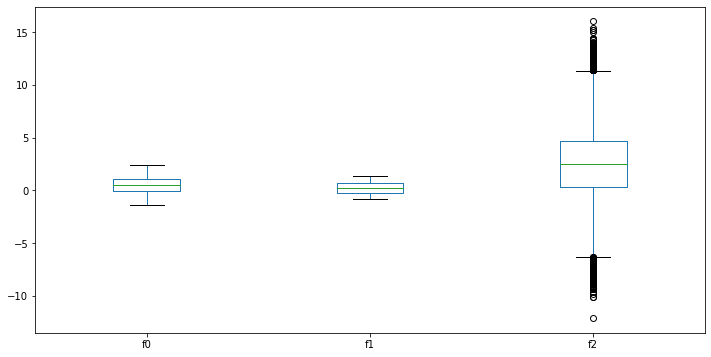

In [7]:
#посмотрим наличие выбросов для признаков на диаграмме
columns_to_plot = ['f0', 'f1', 'f2']    

df1_raw[columns_to_plot].plot(kind='box', figsize=(12,6))
None

Похоже, что в первом датасете целевой признак product коррелирует с f2. Пропущенных значений нет. В столбце id есть дубликаты для 20 строк. Это не большое количество и его можно удалить, но предварительно необходимо более подробно их рассмотреть. Данные распределены нормально для признака f2. Столбец id необходимо будет удалить для всех датасетов, поскольку не имеет значения при обучении. 

In [ ]:
'''подробный отчет создан при помощи Profiling Report

profile(df2_raw)
'''

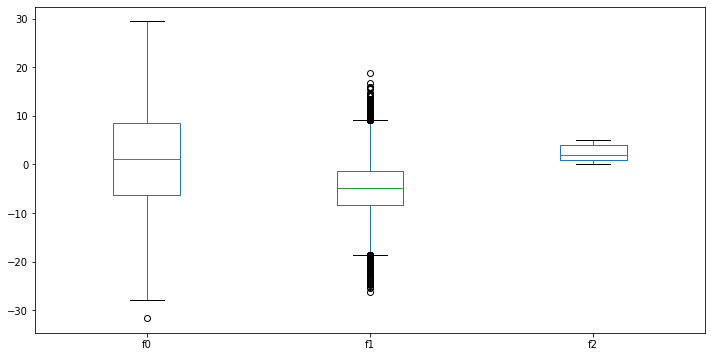

In [9]:
#посмотрим наличие выбросов для признаков на диаграмме  
df2_raw[columns_to_plot].plot(kind='box', figsize=(12,6))
None

Данные распределены нормально для признака f1. Замечена высокая корреляция между признаками product и f2. Кроме того, замечена невысокая мультиколлинеарность признаков f0 и f1. В данном датасете также присутвуют дубликаты в столбце id в количестве 8 значений. 

In [ ]:
'''подробный отчет создан при помощи Profiling Report

profile(df3_raw)
'''

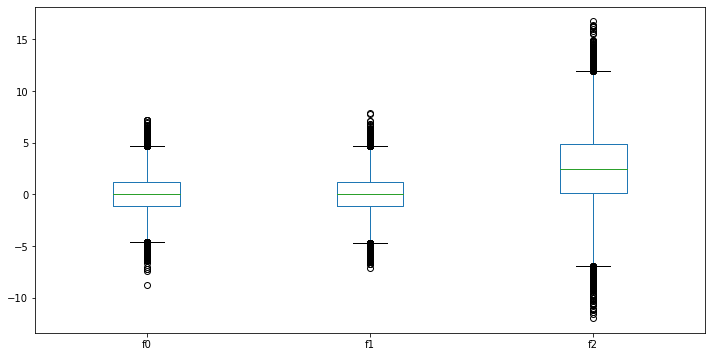

In [11]:
#посмотрим наличие выбросов для признаков на диаграмме
df3_raw[columns_to_plot].plot(kind='box', figsize=(12,6))
None

Последний датасет не имеет пропусков и корреляции признаков, но есть небольшое количество дубликатов в столбце id. Распределение нормальное для всех значений. Признак f2 сильно коррелирует с целевым признаком product.

In [12]:
#посмотрим на дубликаты в датасете для первого региона
col = df1_raw['id']
df1_raw[col.isin(col[col.duplicated()])].sort_values('id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Можно заметить, что строки не дублируются полностью. Причина, по которой для некоторых скважин имеются разные данные замеров/характеристик, неизвестна. Для некоторых скважин данные по выбоработке сильно отличаются для первого и второго, предположительно, замера. Поскольку нам неизвестно, какие данные в данном случае актуальны, оставим датасеты без изменений.

In [13]:
#удалим столбец id из всех датасетов
def drop_col(df, col):
    """ 
    Удаление столбцов из датафрейма.
    Входные параметры: датафрейм, название столбца.
    На выходе получен датафрейм без соотвествующего столбца.
    """
    df_num = df.drop([col], axis=1)
    return df_num

df_1 = drop_col(df1_raw, 'id')
df_2 = drop_col(df2_raw, 'id')
df_3 = drop_col(df3_raw, 'id')

В целом данные не содержат пропуски и имеют нормальное рампределение, но имеются выбросы в некоторых признаках. Встречается небольшой процент дубликатов в столбце id. Некоторые признаки коррелируют между собой. Но поскольку данные закодированы, не целесообразно удалять коррелирующие признаки в слепую. После удаления незначащего признака разделим выборки и выполним масштабирование.

## Обучение и проверка модели

In [14]:
#создадим общую выборку с признаками и целевыми значениями
def data_split(df):
    """ 
    Создание выборок для обучения модели.
    Входные параметры: датафрейм.
    На выходе получены датафреймы тренировочных и валидационных признаков и целей.
    """
    X = df.drop(['product'], axis=1)
    y = df['product']
    
    #выделим набор данных для обучающей, валидационной выборки 
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, shuffle=True, test_size=0.25, stratify=None, random_state=12345)
    
    return X_train, X_valid, y_train, y_valid


X_train_1, X_valid_1, y_train_1, y_valid_1 = data_split(df_1)
X_train_2, X_valid_2, y_train_2, y_valid_2 = data_split(df_2)
X_train_3, X_valid_3, y_train_3, y_valid_3 = data_split(df_3)

In [15]:
#проверим, как выполнилось деление выборок
print('dataset 1')
print(X_train_1.shape)
print(X_valid_1.shape)
print(y_train_1.shape)
print(y_valid_1.shape)
print('dataset 2')
print(X_train_2.shape)
print(X_valid_2.shape)
print(y_train_2.shape)
print(y_valid_2.shape)
print('dataset 3')
print(X_train_3.shape)
print(X_valid_3.shape)
print(y_train_3.shape)
print(y_valid_3.shape)

dataset 1
(75000, 3)
(25000, 3)
(75000,)
(25000,)
dataset 2
(75000, 3)
(25000, 3)
(75000,)
(25000,)
dataset 3
(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [16]:
#выполним масштабирование признаков

#определим численные столбцы для масштабирования
numeric = ['f0', 'f1', 'f2']

#определим инструмент для масштабирования и обучим и применим на тренировочных данных
scaler_1 = RobustScaler()
X_train_1[numeric] = scaler_1.fit_transform(X_train_1[numeric])

X_train_2[numeric] = scaler_1.fit_transform(X_train_2[numeric])

#данные для третьего региона распределены нормально для всех признаков, 
#поэтому используем стандартный метод масштабирования
scaler_2 = StandardScaler()
X_train_3[numeric] = scaler_2.fit_transform(X_train_3[numeric])

#применим масштабирование для валидационных выборок
X_valid_1[numeric] = scaler_1.transform(X_valid_1[numeric])
X_valid_2[numeric] = scaler_1.transform(X_valid_2[numeric])
X_valid_3[numeric] = scaler_2.transform(X_valid_3[numeric])

In [17]:
model = LinearRegression()# инициализируем модель LinearRegression

#определим функцию для олучения предсказаний для всех регионов
def predictions(X_train, y_train, X_valid, y_valid):
    """ 
    Получение предсказаний.
    Входные параметры: тренировочные и валидационные выборки признаков и целей.
    В ходе работы функции обучается модель, выполняются предсказания и 
    расчитывается метрика средней квадратичной ошибки.
    На выходе получены датафреймы с предсказанием и метрика rmse.
    """
    model.fit(X_train, y_train)
    prediction = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, prediction)**0.5
    
    return prediction, rmse

prediction_1, rmse_1 = predictions(X_train_1, y_train_1, X_valid_1, y_valid_1)
prediction_2, rmse_2 = predictions(X_train_2, y_train_2, X_valid_2, y_valid_2)
prediction_3, rmse_3 = predictions(X_train_3, y_train_3, X_valid_3, y_valid_3)

In [18]:
#зададим названия столбцов для нового датафрейма
column = ['Средний запас', 'RMSE']

#объединим данные с результатами
all_data = (
    [["%.2f" % prediction_1.mean(), "%.2f" % rmse_1],
     ["%.2f" % prediction_2.mean(), "%.2f" % rmse_2],
     ["%.2f" % prediction_3.mean(), "%.2f" % rmse_3]])

#добавим данные в датафрейм и выведем тадлицу
all_res = pd.DataFrame(data=all_data, columns=column).astype(float)
all_res.index = ['Регион_1', 'Регион_2', 'Регион_3']

all_res

,Средний запас,RMSE
Регион_1,88.01,40.00
Регион_2,68.73,0.89
Регион_3,94.97,40.03


Лучшие предсказания получились для данных из второго региона. Это можно объяснить тем, что признак 'f2' показал высокую корреляцию с целевым 'product'. Наименьший средний запас также получен для второго региона.

## Подготовка к расчёту прибыли

In [19]:
# найдем стоимость разработки одной скважины
budget_per_id = BUDGET / ID_RESULT

# Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины
product_profit_min = budget_per_id / PRICE

print('Минимальный объем сырья:', "%.2f" % product_profit_min)

Минимальный объем сырья: 111.11


In [20]:
#сравним со средним значеним для каждого региона
column = ['Средний запас (реальный)']

profit_real = (
    [["%.2f" % df_1['product'].mean()],
     ["%.2f" % df_2['product'].mean()],
     ["%.2f" % df_3['product'].mean()]])

#добавим данные в датафрейм и выведем тадлицу
profit_data = pd.DataFrame(data=profit_real, columns=column).astype(float)
profit_data.index = ['Регион_1', 'Регион_2', 'Регион_3']

profit_data['Разница'] = profit_data['Средний запас (реальный)'] - product_profit_min
profit_data

,Средний запас (реальный),Разница
Регион_1,92.50,-18.611111
Регион_2,68.83,-42.281111
Регион_3,95.00,-16.111111


Минимальный объем сырья, гарантирующий безубыточную разработку скважины составил 111 тыс. баррелей. Наименьшая разница с предсказанным средним показателем добычи получена для третьего региона. Наибольшая разница - для второго. 

## Расчёт прибыли и рисков 

In [21]:
# Создадим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели
def revenue(prediction, count):
    """ 
    Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели.
    Входные параметры: датафрейм с предсказанием и количество 
    скважин для разработки.
    В ходе работы функция отбирает 200 скважин с максимальными значениями 
    предсказаний, производит суммирование выработки
    и вычисляет общую потенциальную прибыль.
    На выходе получена прибыль для полученного объёма сырья.
    """
    for i in prediction:
        prediction_sorted = sorted(i, reverse=True)
        selected = prediction_sorted[:count]
        total = sum(selected)
        total_price = total * PRICE   
    return total_price

# закрепим рандомные значения в параметре
state = np.random.RandomState(12345)

#создадим функцию для реализации бутстрепа
def calcul(X_train, y_train, X_valid, y_valid):
    """ 
    Функция для реализации бутстрепа при подсчете прибыли.
    Входные параметры: тренировочные и валидационные выборки признаков и целей
    для выборанного региона.
    В ходе работы функция создает 1000 случайных распределений признаков и целей размером 500 строк.
    Далее обучают модели и получают 1000 выборок с предсказаниями.
    Следующим шагом применяется функция revenue. 
    На выходе получено распределение прибыли для выбранного региона.
    """
    values = []
    income = []
    for i in range(1000):
        X_train_subsample = X_train.sample(n=500, replace=True, random_state=state)
        y_train_subsample = y_train[X_train_subsample.index]
        X_valid_subsample = X_valid.sample(n=500, replace=True, random_state=state)
        y_valid_subsample = y_valid[X_valid_subsample.index]
        
        model.fit(X_train_subsample, y_train_subsample) #обучение модели на тренировочных данных
        pred = model.predict(X_valid_subsample) # предсказание на валидационных данных
        values.append(pred) #все предсказания 1000х500
        income.append(revenue(values, ID_RESULT)) #прибыль 1000 строк по 200 лучших
    
    return income   


result_1 = calcul(X_train_1, y_train_1, X_valid_1, y_valid_1) 
result_2 = calcul(X_train_2, y_train_2, X_valid_2, y_valid_2)
result_3 = calcul(X_train_3, y_train_3, X_valid_3, y_valid_3)

In [22]:
#создадим функцию для получения целевых результатов для каждого региона
def result_list(result_file):  
    """ 
    Функция для получения результатов.
    Входные параметры: распределение прибыли для выбранного региона. 
    На выходе получены значения средняя прибыль, границы 95%-го доверительного интервала
    и вероятность убытков для выбранного региона в виде списка.
    """
    j = 0
    for item in result_file:
        profit = item - BUDGET
        if profit < 0:
            j += 1
    risk = j / 1000 * 100 # вероятность убытков в %
    
    result_series = pd.Series(result_file)
   
    mean = result_series.mean() - BUDGET # средняя выручка
    lower = result_series.quantile(0.025) - BUDGET # нижняя граница доверительного интервала
    upper = result_series.quantile(0.975) - BUDGET # верхняя граница доверительного интервала

    row_results = [mean, lower, upper, risk]
    
    return row_results

In [23]:
pd.options.display.float_format = '{:.2f}'.format #зададим настройку ограничивающую точность значений

all_files = [result_1, result_2, result_3] # объединим все результаты в один список

# получим таблицу с ключевыми результатами для всех регионов
table = []
for file in all_files: 
    row = result_list(file)
    table.append(row)

# преобразуем полученные данные в датафрейм
all_results = pd.DataFrame(table)       

# настроим таблицу результатов 
column = ['Средняя прибыль, млн', 'Нижняя граница Д.И., млн', 'Верхняя граница Д.И., млн', 'Риск убытков %']
all_results.columns = column
all_results.index = ['Регион_1', 'Регион_2', 'Регион_3']
all_results.loc[:, 'Средняя прибыль, млн': 'Верхняя граница Д.И., млн'] \
= all_results.loc[:, 'Средняя прибыль, млн': 'Верхняя граница Д.И., млн'].apply(lambda x: x/1000000)

# выведем итоговую таблицу
all_results

,"Средняя прибыль, млн","Нижняя граница Д.И., млн","Верхняя граница Д.И., млн",Риск убытков %
Регион_1,671.92,-22.91,1419.97,3.30
Регион_2,438.38,34.26,850.76,1.90
Регион_3,284.75,-152.10,726.02,9.80


Наиболее подходящий регион для разработки - второй регион. По результатам проверки работы модели обучения на большом количестве выборок в ходе бутстрепа дало средний показатель прибыли равный 438 миллиона рублей. Доверительный интервал, составляющий 95% выборки - от 34 млн. до 851 млн. рублей. Вероятность убытков составила 1.9%, что меньше порогового значения 2.5%. Для остальных регионов вероятность убытков выше, поэтому, регионы 1 и 3 нельзя рекомендовать для разработки при текущих условиях.

## Выводы



<b>В результате выполнения проекта решена задача и достигнута цель - выбран 2 регион для потенциальной разработки, поскольку вероятность убытков там составила менее 2.5%</b>


<b>Выполнены следующие этапы:</b>
1. Исходные данные загружены, проанализированы и обработаны;
2. Обучена модель линейной регрессии для каждого региона:
   - Данные разбиты на тренировочные и валидационные;
   - Признаки отмасштабированы;
   - Обучена модель, получены предсказания;
   - Получен средний запас предсказанного сырья и RMSE всех моделей.
3. Выполнены предварительные вычисления для расчета прибыли:
   - Все ключевые значения для расчётов сохранены в отдельных переменных;
   - Расчитан достаточный объём сырья для безубыточной разработки новой скважины - 111.11 тыс. баррелей;
   - Выполнено сравнение полученного объёма сырья со средним запасом в каждом регионе.
4. Расчитана прибыль и риски убыточной разработки для каждого региона:
   - Написана функция для расчёта прибыли по выбранным скважинам и предсказаниям модели;
   - Рассчитана прибыль для полученного объёма сырья.
   - Рассчитана средняя прибыль, 95%-й доверительный интервал и риск убытков;
   - Предложен регион для разработки скважин.